# Sentiment Analysis model development (IMDB dataset)
###For TrendSentimentAnalysis (tsa.)
Joyster Rodrigues | 2018487


**Instructions:**
Please download and store the dataset in the 'Files' section upon connecting to a runtime </br>
Download the dataset from [original source](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) or from [this link](https://drive.google.com/drive/folders/19AwC_aP13RTJBK7Xx2J0-Q50W14Nmam8?usp=share_link)

# Importing dependencies and dataset

In [ ]:
# imports
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))

In [ ]:
# import data
dataset = pd.read_csv('./IMDB Dataset.csv')
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Analysing and pre-processing IMDB dataset

In [ ]:
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
backup_df = dataset.copy()
dataset = dataset.drop_duplicates()

In [ ]:
dataset.value_counts('sentiment')

sentiment
positive    24884
negative    24698
dtype: int64

In [ ]:
def preprocess_data(text):
  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text()

  text = text.lower()

  text = re.sub('[^a-zA-Z]', ' ', text)

  return text

In [ ]:
dataset['review_processed'] = dataset['review'].apply(preprocess_data)

<ipython-input-8-2a8f140146ad>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset['review_processed'] = dataset['review_processed'].apply(remove_stopwords)

In [ ]:
dataset['review_processed'].head()

0    one reviewers mentioned watching oz episode ho...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically family little boy jake thinks zombie...
4    petter mattei love time money visually stunnin...
Name: review_processed, dtype: object

In [ ]:
def sentiment_id(sentiment):
  if sentiment == 'positive':
    sent_id = 1
  else:
    sent_id = 0
  return sent_id

In [ ]:
dataset['sentiment_id'] = dataset['sentiment'].apply(sentiment_id)

In [ ]:
dataset.describe(include='all')

,review,sentiment,review_processed,sentiment_id
count,49582,49582,49582,49582.000000
unique,49582,2,49575,NaN
top,One of the other reviewers has mentioned that ...,positive,opportunity watch filming slavic village broad...,NaN
freq,1,24884,2,NaN
mean,NaN,NaN,NaN,0.501876
std,NaN,NaN,NaN,0.500002
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,1.000000


In [ ]:
dataset.head()

,review,sentiment,review_processed,sentiment_id
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset['review_processed'], dataset['sentiment_id'], test_size=0.2, random_state=42)

In [ ]:
print(f'{len(x_train)} | {len(x_test)}')

39665 | 9917


## Tokenizing and Vectorising data

In [ ]:
tokenizer = Tokenizer(
    num_words=10000, 
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True, 
    oov_token='<00V>'
)

In [ ]:
tokenizer.fit_on_texts(x_train)

In [ ]:
x_train_vectors = tokenizer.texts_to_sequences(x_train)
x_test_vectors = tokenizer.texts_to_sequences(x_test)

In [ ]:
max_length = 200
x_train_padded = pad_sequences(x_train_vectors, maxlen=max_length, padding='pre', truncating='pre')
x_test_padded = pad_sequences(x_test_vectors, maxlen=max_length, padding='pre', truncating='pre')

In [ ]:
print(x_train[:1])

7837    really liked movie emporer new groove watching...
Name: review_processed, dtype: object


In [ ]:
print(x_train_vectors[:1])

[[12, 309, 2, 1, 71, 7545, 56, 5, 427, 226, 198, 200, 4453, 1, 466, 2, 15, 5, 1150, 5991, 1030, 7697, 314, 740, 288, 8, 40, 206, 49, 1304, 249, 107, 2602, 2, 5, 116, 62, 1784, 160, 1, 62, 1838, 888, 18, 238, 24, 1123, 1, 71, 7545, 77, 62, 888, 1, 5684, 2, 232, 232, 98]]


In [ ]:
print(x_train_padded[:1])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   12  309    2    1   71 7545   56    5  427  226  198  200 4453
     1  466    2   15    5 1150 5991 1030 7697  314  740  288    8   40
   206   49 1304  249  107 2602    2    5  116   62 1784  160    1   62
  1838  888   18  238   24 1123    1   71 7545   77   62  888   

# Defining Model architectures and training

## model 1

In [ ]:
# Define simple sequential feed-forward model
model1 = Sequential()
model1.add(Embedding(input_dim=10000, output_dim=32, input_length=max_length))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6401      
                                                                 
Total params: 326,401
Trainable params: 326,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
hist1 = model1.fit(x_train_padded, y_train, epochs=8, batch_size=32, validation_data=(x_test_padded, y_test))

Epoch 1/8
1240/1240 [==============================] - 16s 12ms/step - loss: 0.3643 - accuracy: 0.8328 - val_loss: 0.2734 - val_accuracy: 0.8873
Epoch 2/8
1240/1240 [==============================] - 15s 12ms/step - loss: 0.1908 - accuracy: 0.9277 - val_loss: 0.2818 - val_accuracy: 0.8852
Epoch 3/8
1240/1240 [==============================] - 15s 12ms/step - loss: 0.1053 - accuracy: 0.9684 - val_loss: 0.3128 - val_accuracy: 0.8809
Epoch 4/8
1240/1240 [==============================] - 25s 20ms/step - loss: 0.0444 - accuracy: 0.9920 - val_loss: 0.3554 - val_accuracy: 0.8768
Epoch 5/8
1240/1240 [==============================] - 21s 17ms/step - loss: 0.0170 - accuracy: 0.9980 - val_loss: 0.3980 - val_accuracy: 0.8773
Epoch 6/8
1240/1240 [==============================] - 14s 11ms/step - loss: 0.0066 - accuracy: 0.9996 - val_loss: 0.4561 - val_accuracy: 0.8739
Epoch 7/8
1240/1240 [==============================] - 19s 15ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4909 - val_ac

## model 2

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=10000, output_dim=32, input_length=max_length))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
hist2 = model2.fit(x_train_padded, y_train, epochs=3, batch_size=64, validation_data=(x_test_padded, y_test))

Epoch 1/3
620/620 [==============================] - 92s 146ms/step - loss: 0.4209 - accuracy: 0.8061 - val_loss: 0.3108 - val_accuracy: 0.8725
Epoch 2/3
620/620 [==============================] - 64s 103ms/step - loss: 0.2613 - accuracy: 0.8976 - val_loss: 0.3227 - val_accuracy: 0.8627
Epoch 3/3
620/620 [==============================] - 54s 86ms/step - loss: 0.2101 - accuracy: 0.9206 - val_loss: 0.3319 - val_accuracy: 0.8730


## model 3

In [ ]:
model3 = Sequential()
model3.add(Embedding(input_dim=10000, output_dim=32, input_length=max_length))
model3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 32)           320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 369,793
Trainable params: 369,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
hist3 = model3.fit(x_train_padded, y_train, epochs=3, batch_size=64, validation_data=(x_test_padded, y_test))

Epoch 1/3
620/620 [==============================] - 628s 974ms/step - loss: 0.3746 - accuracy: 0.8309 - val_loss: 0.3243 - val_accuracy: 0.8820
Epoch 2/3
620/620 [==============================] - 597s 963ms/step - loss: 0.2331 - accuracy: 0.9099 - val_loss: 0.2787 - val_accuracy: 0.8860
Epoch 3/3
620/620 [==============================] - 602s 970ms/step - loss: 0.1886 - accuracy: 0.9277 - val_loss: 0.3095 - val_accuracy: 0.8840


## model 4

In [ ]:
model4 = Sequential()
model4.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
model4.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)               

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model4.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Train the model with callbacks
history = model4.fit(x_train_padded, y_train, batch_size=128, epochs=10, validation_data=(x_test_padded, y_test), callbacks=[checkpoint, early_stop])

# Load the best model
model4.load_weights("best_model.h5")

In [ ]:
model4.load_weights("best_model4.h5")

# Testing & Evaluation

## Simple tests

In [ ]:
# Define the sentences
sentences = ["I'm having a great day today!", "I wish I never left the bed, terrible weather today!"]

# Convert the sentences to sequences of integers
sequences = tokenizer.texts_to_sequences(sentences)

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [ ]:
# Make predictions with the model
predictions1 = model1.predict(padded_sequences)
predictions2 = model2.predict(padded_sequences)
predictions3 = model3.predict(padded_sequences)


1/1 [==============================] - 1s 561ms/step


In [ ]:
predictions4 = model4.predict(padded_sequences)

1/1 [==============================] - 1s 992ms/step


In [ ]:
# Print the predictions
for i in range(len(sentences)):
    sentiment = 'positive' if np.round(predictions1[i]) == 1 else 'negative'
    print(f"Sentence: {sentences[i]}")
    print(f"Sentiment: {sentiment}")
print(f'prediction vals: {predictions1}')

Sentence: I'm having a great day today!
Sentiment: positive
Sentence: I wish I never left the bed, terrible weather today!
Sentiment: negative
prediction vals: [[0.9803427 ]
 [0.12452424]]


In [ ]:
# Print the predictions
for i in range(len(sentences)):
    sentiment = 'positive' if np.round(predictions2[i]) == 1 else 'negative'
    print(f"Sentence: {sentences[i]}")
    print(f"Sentiment: {sentiment}")
print(f'prediction vals: {predictions2}')

Sentence: I'm having a great day today!
Sentiment: positive
Sentence: I wish I never left the bed, terrible weather today!
Sentiment: negative
prediction vals: [[0.94231117]
 [0.18582535]]


In [ ]:
# Print the predictions
for i in range(len(sentences)):
    sentiment = 'positive' if np.round(predictions3[i]) == 1 else 'negative'
    print(f"Sentence: {sentences[i]}")
    print(f"Sentiment: {sentiment}")
print(f'prediction vals: {predictions3}')

Sentence: I'm having a great day today!
Sentiment: positive
Sentence: I wish I never left the bed, terrible weather today!
Sentiment: negative
prediction vals: [[0.92438066]
 [0.44277924]]


In [ ]:
# Print the predictions
for i in range(len(sentences)):
    sentiment = 'positive' if np.round(predictions4[i]) == 1 else 'negative'
    print(f"Sentence: {sentences[i]}")
    print(f"Sentiment: {sentiment}")
print(f'prediction vals: {predictions4}')

Sentence: I'm having a great day today!
Sentiment: positive
Sentence: I wish I never left the bed, terrible weather today!
Sentiment: negative
prediction vals: [[0.7605904 ]
 [0.13962902]]


## Model training and validation: accuracy vs loss

In [ ]:
def create_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()


### Model 1

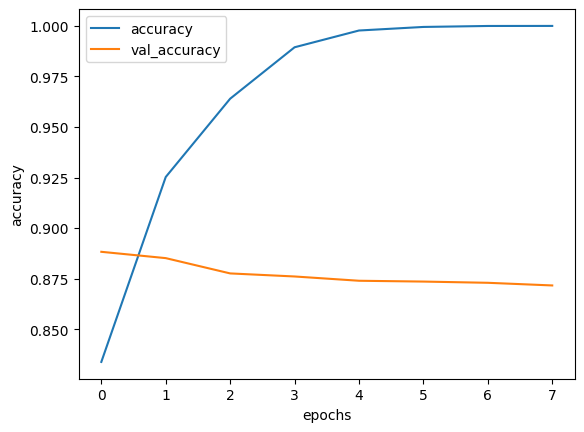

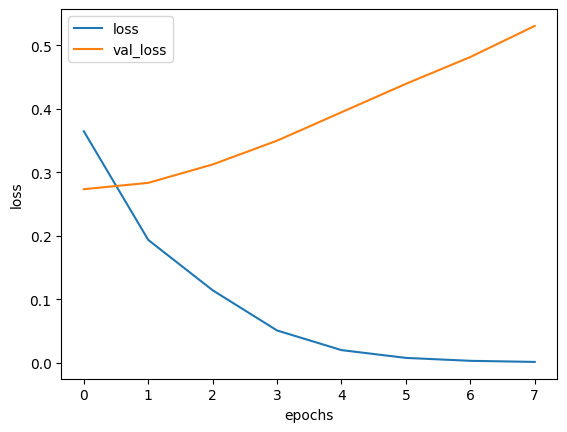

In [ ]:
create_graph(hist1, 'accuracy')
create_graph(hist1, 'loss')

### Model 2

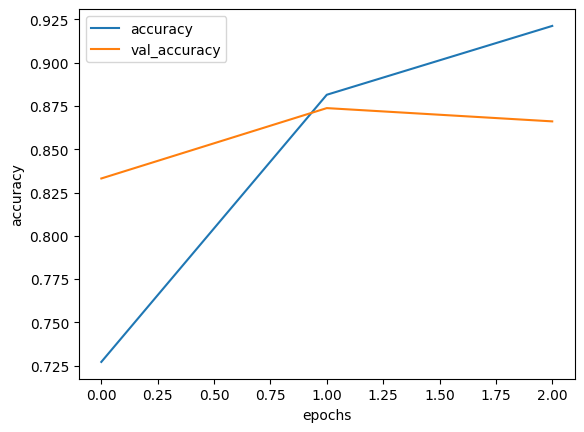

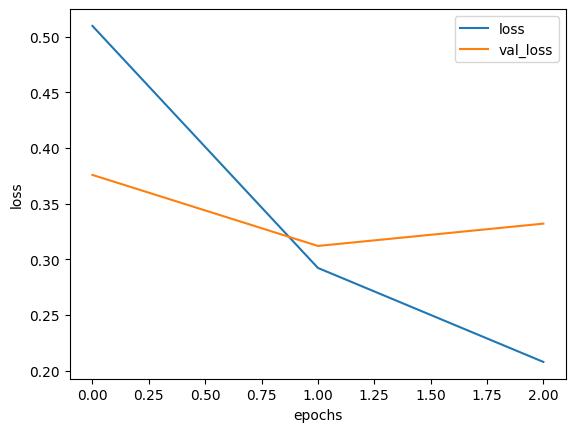

In [ ]:
create_graph(hist2, 'accuracy')
create_graph(hist2, 'loss')

### Model 3

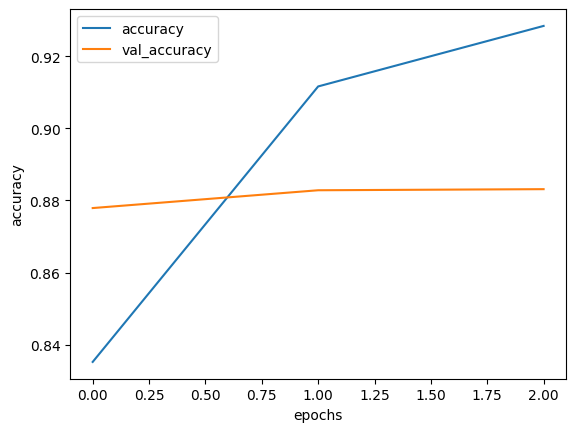

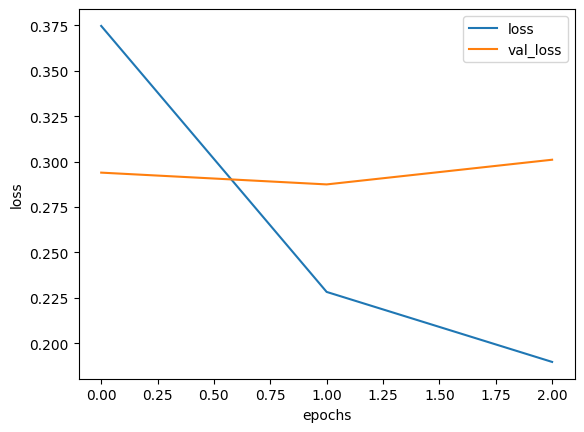

In [ ]:
create_graph(hist3, 'accuracy')
create_graph(hist3, 'loss')

### Model 4

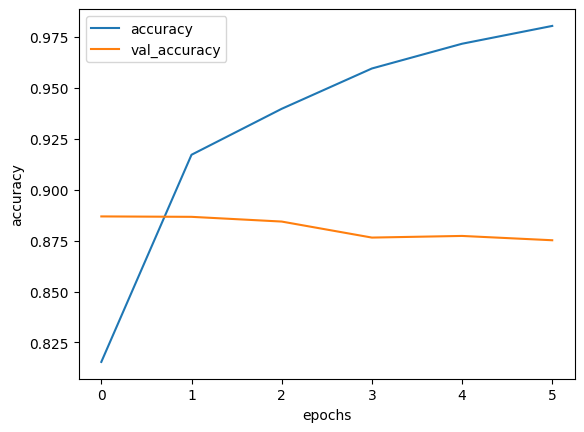

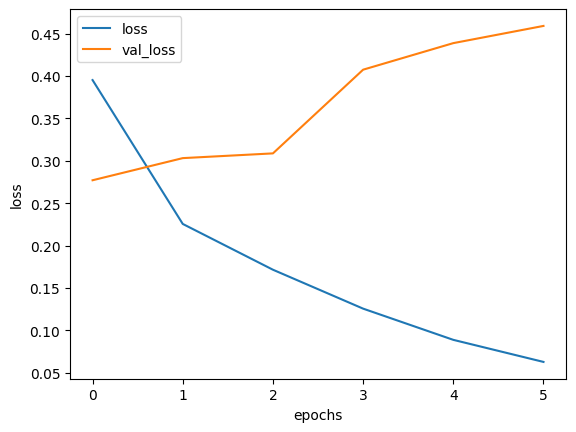

In [ ]:
create_graph(history, 'accuracy')
create_graph(history, 'loss')

model 4 is discarded due it it's poor potential performance and the hike in val_loss shown in graph above. 

# Further Evaluation

## Confusion Matrix

In [ ]:
def conf_matrix(model):
  y_true = y_test.values
  y_pred = model.predict(x_test_padded)
  y_pred = np.where(np.round(y_pred)>0.5,1,0)


  conf_matrix = confusion_matrix(y_true, y_pred)

  # confusion matrix
  print(conf_matrix)

  sns.heatmap(conf_matrix, cmap='YlGn', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

310/310 [==============================] - 1s 2ms/step
[[4177  762]
 [ 511 4467]]


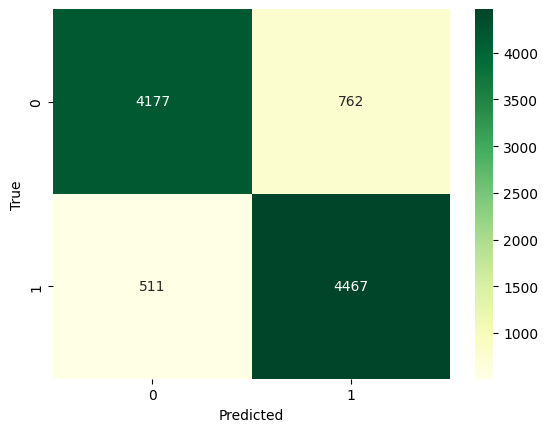

310/310 [==============================] - 4s 14ms/step
[[4407  532]
 [ 796 4182]]


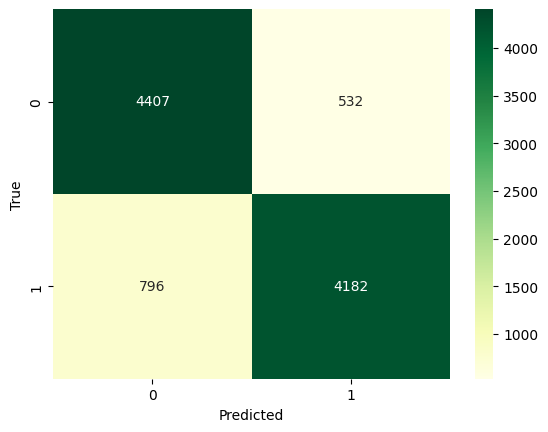

310/310 [==============================] - 28s 91ms/step
[[4310  629]
 [ 530 4448]]


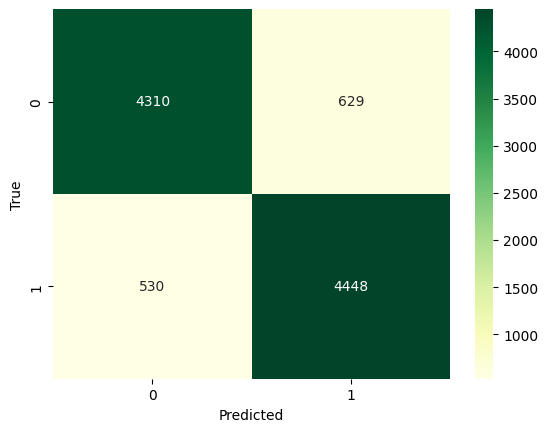

In [ ]:
conf_matrix(model1)
conf_matrix(model2)
conf_matrix(model3)

## Classification Report

In [ ]:
def class_report(model):
    y_true = y_test.values
    y_pred = model.predict(x_test_padded)
    y_pred = np.where(np.round(y_pred)>0.5,1,0)

    print(classification_report(y_test, y_pred))

In [ ]:
class_report(model1)
class_report(model2)
class_report(model3)

310/310 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4939
           1       0.85      0.90      0.88      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917

310/310 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4939
           1       0.89      0.84      0.86      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917

310/310 [==============================] - 28s 89ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.88      4978

    accuracy  

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True)
tf.keras.utils.plot_model(model2, show_shapes=True)
tf.keras.utils.plot_model(model3, show_shapes=True)

# Exporting models and tokenizer for tsa

In [ ]:
# save models 
model1.save('senti_model1')
model1.save('senti_model1.h5')

model2.save('senti_model2')
model2.save('senti_model2.h5')

model3.save('senti_model3')
model3.save('senti_model3.h5')


In [ ]:
from google.colab import files
!cp -r '/content/senti_model1' "/content/drive/MyDrive/finalest"
!cp -r '/content/senti_model1.h5' "/content/drive/MyDrive/finalest"

!cp -r '/content/senti_model2' "/content/drive/MyDrive/finalest"
!cp -r '/content/senti_model2.h5' "/content/drive/MyDrive/finalest"

!cp -r '/content/senti_model3' "/content/drive/MyDrive/finalest"
!cp -r '/content/senti_model3.h5' "/content/drive/MyDrive/finalest"

In [ ]:
# save tokenizer
import pickle
with open('senti_tokenzier.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
!cp -r '/content/senti_tokenzier.pickle' "/content/drive/MyDrive/finalest"

# Citation

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}

www.kaggle.com. (n.d.). IMDB Dataset of 50K Movie Reviews. [online] Available at: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews.

‌